# Contrast Curves

Applefy provides two methods for calculating detection limits: **Analytical Contrast Curves** and **Contrast Grids**. 

This tutorial focuses on **analytical contrast curves** as described in Appendix A of [(Bonse et al. 2023)](../05_citation.rst). Analytical contrast curves are less computationally demanding than contrast grids, but they do require a linear post-processing algorithm (like PCA).

For more examples see also [Figure 10](../04_apples_with_apples/paper_experiments/10_contrast_curves_compared.ipynb) and [Figure 13](../04_apples_with_apples/paper_experiments/13_Contrast_Grid_vs_Contrast_Curve.ipynb).

## Imports

In [1]:
from pathlib import Path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate

from applefy.detections.contrast import Contrast

from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, gaussian_sigma_2_fpf, \
    fpf_2_gaussian_sigma, LaplaceBootstrapTest

from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio

## Mathematical Background

Let $f_p$ be the flux of a potentail planet and $f_*$ be the flux of its host star. We want to find the contrast 

$c = f_p / f_*$ 

for which we can still detect the planet. The **key challenge** for contrast calculations in high contrast imaging is that the flux of the **planet in our residual image**, i.e. after data post-processing, **is not** $f_p$. Consider the following example of a residual.

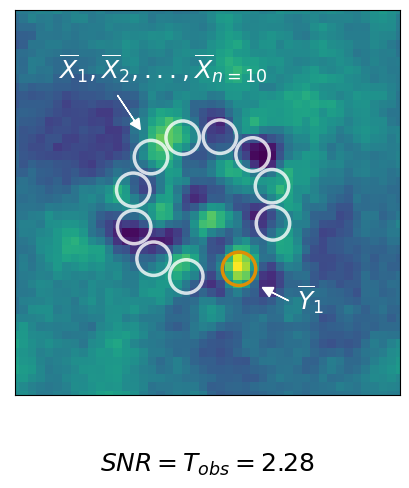

In [2]:
from IPython import display
display.Image("../04_apples_with_apples/paper_experiments/01_01_observation.png")

The values of $\overline{X}_1, ..., \overline{X}_n$ are our noise observations and $\overline{Y}_1$ is the signal of the potential planet. We use a two sample t-test as our detection criterion and calculate $T_{\text{obs}}$:

\begin{equation}
\label{eq:snr}
T_{\text{obs}} = \frac{\overline{Y}_1 - \hat{\mu}_\mathcal{X}}{\hat{\sigma}_{\mathcal{X}} \sqrt{1 + 1/n}}
\end{equation}

The mean estimates of the noise sample is denoted as $\hat{\mu}_{\mathcal{X}}$, while $\hat{\sigma}_{\mathcal{X}}$ is the Bessel corrected standard deviation of $\overline{X}_1, ..., \overline{X}_n$. Using the t-distribution we get the p-value of the test which gives us the remaining risk that our detection is just noise (about 2.4\% in the given example).

In [3]:
test = TTest()
test.t_2_fpf(2.28, num_noise_values=10)

0.024281242430317512

Note that due to the effect of the sample size, one value of $T_{\text{obs}}$ can result in different p-values depending on the separation from the star. In applefy this is controlled by the value of *num_noise_values*.

In [4]:
test = TTest()
test.t_2_fpf(2.28, num_noise_values=100)

0.012376376089204888

If we want to calculate a contrast curve, we want to apply the test in the opposite way. We start by setting a detection threshold, i.e. the p-value we want to achieve. A classic choice would be FPF = 2.87e-7 ($5 \sigma_{\mathcal{N}}$).

In [5]:
gaussian_sigma_2_fpf(5)

2.866515718791933e-07

Given this detection threshold we can calculate the value of $T_{\text{obs}}$ needed such that our hypothetical planet would be counted as a detection.

In [6]:
test.fpf_2_t(gaussian_sigma_2_fpf(5), 
             num_noise_values=10)

12.422024063434902

**Note, that this value depends again on the separation from the star!**

In [7]:
test.fpf_2_t(gaussian_sigma_2_fpf(5), 
             num_noise_values=100)

5.347850176350963

Given the value of $T_{\text{obs}}$ we can calculate the residual planet signal $\overline{Y}_1$ needed for a detection. For this we simply re-arange the equation of the test statistic and assume that the values of $\overline{X}_1, ..., \overline{X}_n$ (and with it $\hat{\mu}_\mathcal{X}$ and $\hat{\sigma}_{\mathcal{X}}$) do not change if the signal $\overline{Y}_1$ gets brighter.

\begin{equation}
\overline{Y}_1 = T_{\text{obs}} \cdot \hat{\sigma}_{\mathcal{X}} \sqrt{1 + 1/n} + \hat{\mu}_\mathcal{X}
\end{equation}

The relationship between the residual planet flux $\overline{Y}_1$ and the true planet flux $f_p$ can be modeled as:

\begin{equation}
\overline{Y}_1 = f_p \cdot \kappa(f_p, s) + X_{n+1}
\end{equation}

where $X_{n+1}$ is the speckle noise at the position of the planet and $\kappa(s) \in [0, 1]$ is the throughput accounting for the attenuation of the data post-processing and potentail coronagraphs (as a function of separation $s$). Applefy calculates $\kappa(s)$ through fake planet experiments. Note, that as discussed in [(Bonse et al. 2023)](../05_citation.rst) this is only possible for linear post-processing algorithms such as PCA.

## Demonstration Data

The following tutorial shows how to compute curves. The data used can be downloaded [from Zenodo](../01_getting_started.md).

In [8]:
root_dir = Path("/path/to/documentation_demos")

In [9]:
dataset_config = {'file_path': Path('30_data/betapic_naco_lp_LR.hdf5'),
                  'stack_key': "science_no_planet",
                  'psf_template_key': "psf_template",
                  'parang_key': 'header_science_no_planet/PARANG',
                  'dit_psf_template': 0.02019,
                  'fwhm_size' : 4.2,
                  'dit_science': 0.2}

In general we need three data arrays to compute contrast curves:

- The **science sequence**: A 3D array with dimensions (time, x, y)
- A list of **parallactic angles** for Angular Differential Imaging (time)
- A 2D **PSF-template** which is used to insert artificial planets and determine the throughput.

We load them from the demonstration  data.

In [10]:
# we need the psf template for contrast calculation
science_data, angles, raw_psf_template_data = load_adi_data(
    root_dir/dataset_config["file_path"],
    data_tag=dataset_config["stack_key"],
    psf_template_tag=dataset_config["psf_template_key"],
    para_tag=dataset_config["parang_key"])

dit_psf_template = dataset_config["dit_psf_template"]
dit_science = dataset_config["dit_science"]
fwhm = dataset_config["fwhm_size"]

psf_template = raw_psf_template_data[82:-82, 82:-82]

## How to compute Contrast Curves

The main interface to calculate analytical contrast curves as well as contrast grids is the class [Contrast](../03_package/detections.rst#applefy.detections.contrast.Contrast). It takes the science sequence, parallactic angles and the PSF-template required to run fake planet experiments. 

It further needs the FWHM of the PSF (can be calculated e.g. with [PynPoint](https://pynpoint.readthedocs.io/en/latest/) or
[VIP](https://vip.readthedocs.io/en/latest/>)) as well as the DIT of both science sequence and PSF-template. 

A checkpoint directroy can be given to store intermediate results (such as residuals). The checkpoint directroy is optional but allows to restore fake planet residuals at a later stage. More information can be found in the [documentation](../03_package/detections.rst#applefy.detections.contrast.Contrast).

In [11]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    checkpoint_dir=root_dir / Path("70_results/contrast_curves"))

### Step 1: Design fake planet experiments

In the first step we **choose** at which **separations** and for which **planet brightness** we want to insert fake planets. By default, separations are selected in steps of 1 FWHM from the central star to the edge of the image. The brightness of the fake planets have to be selected manually ([more information](../03_package/detections.rst#applefy.detections.contrast.Contrast.design_fake_planet_experiments)). 

For analytical contrast curves we can add fake planets which are below the expected contrast (i.e. they should not be detectable). This choice helps to make sure that the values of $\overline{X}_1, ..., \overline{X}_n$ (and with it $\hat{\mu}_\mathcal{X}$ and $\hat{\sigma}_{\mathcal{X}}$) are not affected be the inserted fake planets.

In [12]:
# fake planet brightness
flux_ratio_mag = 14
flux_ratio = mag2flux_ratio(14)

print("Brightness of fake planets in mag: " + str(flux_ratio_mag))
print("Planet-to-star flux ratio: " + str(flux_ratio))

Brightness of fake planets in mag: 14
Planet-to-star flux ratio: 2.5118864315095823e-06


For each cell in the contrast grid we calculate *num_fake_planets* (between min=1 and max=6) planet residuals.

In [13]:
num_fake_planets = 6

contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratio,
    num_planets=num_fake_planets,
    overwrite=True)

Overwriting existing config files.


### Step 2: Run fake planet experiments

In the second step we **insert fake planetes** as chosen in the first step. For each planet we **run the data reduction** algorithm to obtain a residual images. Applefy allows to compute contrast curves with different post-processing algorithms. However, it does not come with any implementation of these techniques. Instead, we use existing implementations in packages like
[PynPoint](https://pynpoint.readthedocs.io/en/latest/) or
[VIP](https://vip.readthedocs.io/en/latest/>). See [wrappers](../03_package/wrappers.rst) for more information.

In the following we use a **classical full-frame PCA** to compute the residuals. But, applefy is not limited to this choice and can be used with any other data-reduction algorithm. Note, that analytical contrast curves can only be calculated with linear subtraction-based methods.

Typically, detection limits depend on the choice of post-processing hyper-parameters (e.g. the number of PCA components). Applefy allows you to compute contrast curves for several hyperparameters simultaneously.

Here is an example of how to use applefy **with PynPoint** (requires a checkpoint_dir).

In [14]:
from applefy.wrappers.pynpoint import MultiComponentPCAPynPoint

In [15]:
components = [5, 10, 20, 30, 50, 75, 100]

**Make sure to choose a scratch folder which has a high bandwidth!**

In [16]:
algorithm_function = MultiComponentPCAPynPoint(
    num_pcas=components,
    scratch_dir=contrast_instance.scratch_dir,
    num_cpus_pynpoint=1)

Here is an example of how to use applefy **with VIP**.

In [ ]:
from applefy.wrappers.vip import MultiComponentPCAvip

In [ ]:
algorithm_function = MultiComponentPCAvip(
    num_pcas_tuple=(5, 100, 10))

Applefy can run multiple fake planet experiments in parallel. If a checkpoint_dir is specified, all residuals will be saved as .fits files. Already existing residuals are restored from the checkpoint_dir. This allows to continue the calculation in case of an error.

In [17]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=algorithm_function,
    num_parallel=32)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:02<00:00, 61.92it/s]


[DONE]


### Step 3: Compute the contrast curve

Once all fake planet experiments are finished we can **compute the contrast curves**. For this we have to choose:
- What is signal and what is noise, i.e. **how do we measure the photometry** of the noise observations and the signal of the fake planets. Applefy allows to use aperture sums and spaced pixel values. A discussion about when to use what is given in [(Bonse et al. 2023)](../05_citation.rst). More details are given in the [documentation](../03_package/utils.rst#applefy.utils.photometry.AperturePhotometryMode).

In [18]:
# Use spaced pixel values
photometry_mode_planet = AperturePhotometryMode(
    "FS", # or "P"
    psf_fwhm_radius=fwhm/2, 
    search_area=0.5)
photometry_mode_noise = AperturePhotometryMode(
    "P", 
    psf_fwhm_radius=fwhm/2)

In [19]:
# Use apertures pixel values
photometry_mode_planet = AperturePhotometryMode(
    "AS", # or "ASS"
    psf_fwhm_radius=fwhm/2, 
    search_area=0.5)

photometry_mode_noise = AperturePhotometryMode(
    "AS",
    psf_fwhm_radius=fwhm/2)

In [20]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

- Which statistical test we want to use i.e. what type of noise we assume for our residual images.

**Option 1:** The classical [t-test](../03_package/statistics.rst#applefy.statistics.parametric.TTest) as discussed in Mawet et al. 2014 (assumes **Gaussian residual noise**).

In [21]:
statistical_test = TTest()

**Option 2:** The [Parametric Bootstrap](../03_package/statistics.rst#applefy.statistics.bootstrapping.LaplaceBootstrapTest) test as discussed in [(Bonse et al. 2023)](../05_citation.rst) (assumes **Laplacian residual noise**). You can download the lookup [from Zenodo](../01_getting_started.md).

In [ ]:
statistical_test = LaplaceBootstrapTest.construct_from_json_file("file/to/lookup_table")

Calculate the contrast curves. The parameter *num_rot_iter* allows to average out the effect of where the planet and noise values are placed on the residual. More information can be found in [Figure 2](../04_apples_with_apples/paper_experiments/02_Rotation.ipynb).

In [22]:
contrast_curves, contrast_errors = contrast_instance.compute_analytic_contrast_curves(
    statistical_test=statistical_test,
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    num_rot_iter=20,
    pixel_scale=0.02718)

Computing contrast curve for PCA (005 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.19s/it]


Computing contrast curve for PCA (010 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.18s/it]


Computing contrast curve for PCA (020 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.18s/it]


Computing contrast curve for PCA (030 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:25<00:00,  1.19s/it]


Computing contrast curve for PCA (050 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.19s/it]


Computing contrast curve for PCA (075 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.18s/it]


Computing contrast curve for PCA (100 components)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:25<00:00,  1.21s/it]


We get two outputs:

- A Pandas table showing the contrast curves (one column for each number of PCA components).
- A Pandas table showing the MAD errors of the contrast curves (one column for each number of PCA components).

In [23]:
contrast_curves

,,PCA (005 components),PCA (010 components),PCA (020 components),PCA (030 components),PCA (050 components),PCA (075 components),PCA (100 components)
separation [$FWHM$],separation [arcsec],,,,,,,
1.0,0.114156,0.065861,0.036111,0.031956,0.196679,0.812831,0.795960,1.048767
2.0,0.228312,0.003530,0.001325,0.002721,0.003571,0.346229,1.108886,0.064174
3.0,0.342468,0.001001,0.000423,0.000404,0.000443,0.000950,0.001190,0.001371
4.0,0.456624,0.000420,0.000212,0.000179,0.000229,0.000233,0.000289,0.000240
5.0,0.570780,0.000232,0.000103,0.000097,0.000087,0.000113,0.000103,0.000154
6.0,0.684936,0.000150,0.000101,0.000067,0.000069,0.000085,0.000095,0.000093
7.0,0.799092,0.000135,0.000131,0.000100,0.000093,0.000098,0.000092,0.000089
8.0,0.913248,0.000124,0.000127,0.000078,0.000080,0.000074,0.000070,0.000068
9.0,1.027404,0.000069,0.000064,0.000054,0.000044,0.000038,0.000032,0.000030


## Plot the Contrast Curves

The following code gives an example for how to plot a contrast curves.

In [24]:
# compute the overall best contrast curve
overall_best = np.min(contrast_curves.values, axis=1)

In [25]:
# get the error bars of the the overall best contrast curve
best_idx = np.argmin(contrast_curves.values, axis=1)
best_contrast_errors = contrast_errors.values[np.arange(len(best_idx)), best_idx]

In [26]:
# Find one color for each number of PCA components used.
colors = sns.color_palette(
    "rocket_r", 
    n_colors=len(contrast_curves.columns))
colors

[(0.96575293, 0.73235058, 0.59242739),
 (0.95879054, 0.52628305, 0.36890904),
 (0.92456587, 0.29053388, 0.24242622),
 (0.79085854, 0.10184672, 0.313391),
 (0.58422945, 0.10922707, 0.35848469),
 (0.37459292, 0.12029443, 0.32294825),
 (0.18065495, 0.09009031, 0.22303512)]

In [27]:
separations_arcsec = contrast_curves.reset_index(level=0).index
separations_FWHM = contrast_curves.reset_index(level=1).index

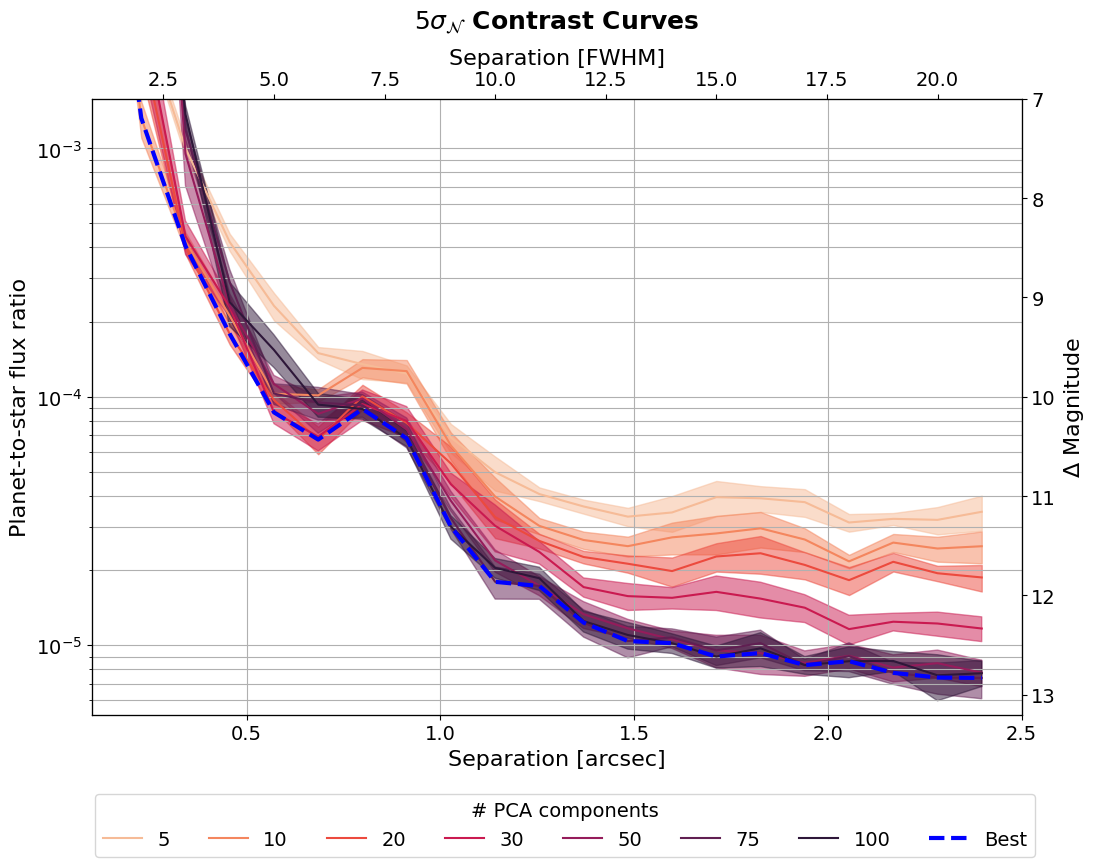

In [28]:
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(12, 8))
gs0 = fig.add_gridspec(1, 1)
axis_contrast_curvse = fig.add_subplot(gs0[0, 0])


# ---------------------- Create the Plot --------------------
i = 0 # color picker

for tmp_model in contrast_curves.columns:
    
    num_components = int(tmp_model[5:9])
    tmp_flux_ratios = contrast_curves.reset_index(
        level=0)[tmp_model].values
    tmp_errors = contrast_errors.reset_index(
        level=0)[tmp_model].values
    
    axis_contrast_curvse.plot(
        separations_arcsec,
        tmp_flux_ratios,
        color = colors[i],
        label=num_components)
    
    axis_contrast_curvse.fill_between(
        separations_arcsec,
        tmp_flux_ratios + tmp_errors, 
        tmp_flux_ratios - tmp_errors,
        color = colors[i],
        alpha=0.5)
    i+=1
    
axis_contrast_curvse.set_yscale("log")
# ------------ Plot the overall best -------------------------
axis_contrast_curvse.plot(
    separations_arcsec,
    overall_best,
    color = "blue",
    lw=3,
    ls="--",
    label="Best")

# ------------- Double axis and limits -----------------------
lim_mag_y = (13.2, 7)
lim_arcsec_x = (0.1, 2.5)
sep_lambda_arcse = interpolate.interp1d(
    separations_arcsec, 
    separations_FWHM, 
    fill_value='extrapolate')

axis_contrast_curvse_mag = axis_contrast_curvse.twinx()
axis_contrast_curvse_mag.plot(
    separations_arcsec,
    flux_ratio2mag(tmp_flux_ratios),
    alpha=0.)
axis_contrast_curvse_mag.invert_yaxis()

axis_contrast_curvse_lambda = axis_contrast_curvse.twiny()
axis_contrast_curvse_lambda.plot(
    separations_FWHM,
    tmp_flux_ratios,
    alpha=0.)

axis_contrast_curvse.grid(which='both')
axis_contrast_curvse_mag.set_ylim(*lim_mag_y)
axis_contrast_curvse.set_ylim(
    mag2flux_ratio(lim_mag_y[0]), 
    mag2flux_ratio(lim_mag_y[1]))

axis_contrast_curvse.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_mag.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_lambda.set_xlim(
    *sep_lambda_arcse(lim_arcsec_x))

# ----------- Labels and fontsizes --------------------------

axis_contrast_curvse.set_xlabel(
    r"Separation [arcsec]", size=16)
axis_contrast_curvse_lambda.set_xlabel(
    r"Separation [FWHM]", size=16)

axis_contrast_curvse.set_ylabel(
    r"Planet-to-star flux ratio", size=16)
axis_contrast_curvse_mag.set_ylabel(
    r"$\Delta$ Magnitude", size=16)

axis_contrast_curvse.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_lambda.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_mag.tick_params(
    axis='both', which='major', labelsize=14)

axis_contrast_curvse_mag.set_title(
    r"$5 \sigma_{\mathcal{N}}$ Contrast Curves",
    fontsize=18, fontweight="bold", y=1.1)

# --------------------------- Legend -----------------------
handles, labels = axis_contrast_curvse.\
    get_legend_handles_labels()

leg1 = fig.legend(handles, labels, 
                  bbox_to_anchor=(0.12, -0.08), 
                  fontsize=14, 
                  title="# PCA components",
                  loc='lower left', ncol=8)

_=plt.setp(leg1.get_title(),fontsize=14)

As you can see the number of PCA components has a large effect on the contrast curves. We can use our analysis to determine the best number of PCA components as a function of separation.

## Best number of PCA components

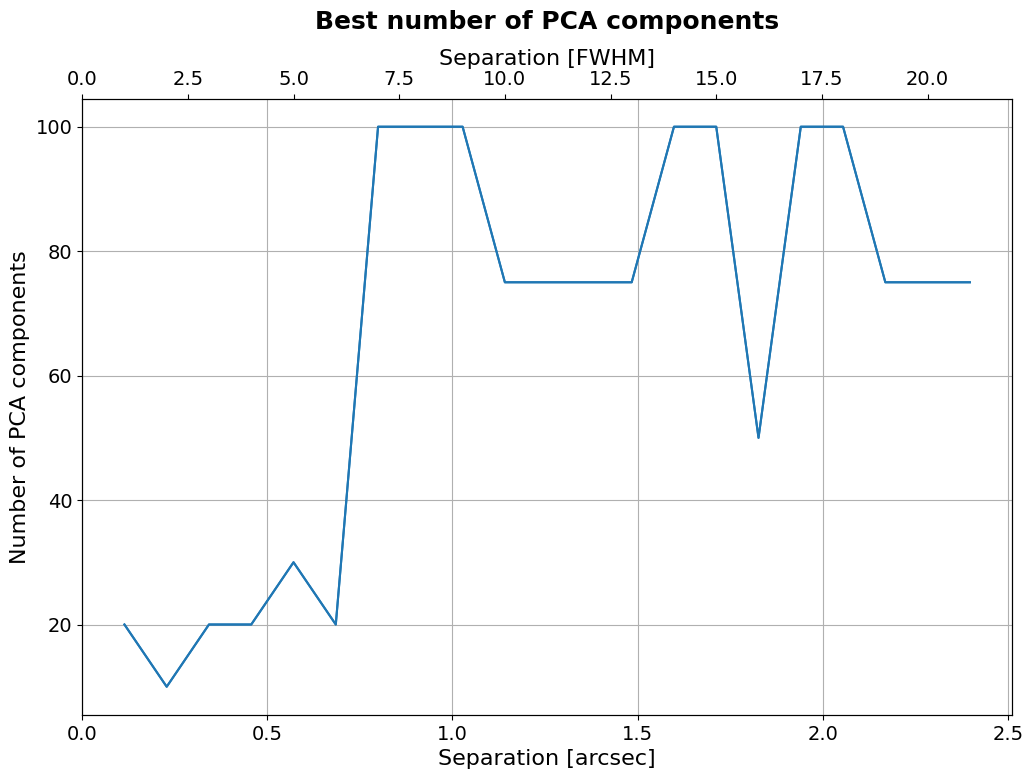

In [29]:
plt.figure(figsize=(12, 8))

plt.plot(separations_arcsec, 
         np.array(components)[np.argmin(
             contrast_curves.values, 
             axis=1)],)

plt.title(r"Best number of PCA components",
          fontsize=18, fontweight="bold", y=1.1)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Separation [arcsec]", fontsize=16)
plt.ylabel("Number of PCA components", fontsize=16)

plt.grid()
ax2 = plt.twiny()
ax2.plot(separations_FWHM, 
         np.array(components)[
             np.argmin(contrast_curves.values, axis=1)],)
ax2.set_xlabel("Separation [FWHM]", fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)